**Oil and Gas Production Prediction by County**
- User inputs commodity type: 'Oil' or 'Gas' that user wants to run the analysis
- User inputs the 'county' name from provided list that user wants to run the analysis

In [1]:
from sqlalchemy import create_engine, MetaData, or_, and_
from sqlalchemy import select, func 
from db_schema import OIL_PROD_TABLE, GAS_PROD_TABLE, LEASE_TABLE, WELLS_TABLE, TOPS_TABLE
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from pmdarima.arima import auto_arima
from pmdarima import model_selection

In [2]:
class CFG:
    img_dim1 = 12
    img_dim2 = 6
    
plt.rcParams.update({'figure.figsize': (CFG.img_dim1,CFG.img_dim2)})

In [3]:
commodity = input('Choose the commodity: Oil or Gas')
#commodity = 'Gas'
print(commodity)

if commodity == 'Oil':
    df = pd.read_csv('../data/oil_by_county.csv')
elif commodity == 'Gas':
    df = pd.read_csv('../data/gas_by_county.csv')
else:
    print('Enter valid input')

df.head()

Oil


,Unnamed: 0,LEASE_KID,PRODUCES,geometry,NAME,DATE,WELLS,PRODUCTION
0,0,1001106119,OIL,POINT (-95.051548 37.928585),Bourbon,1980-01-01,14.0,22.0
1,1,1001106119,OIL,POINT (-95.051548 37.928585),Bourbon,1980-02-01,14.0,99.0
2,2,1001106119,OIL,POINT (-95.051548 37.928585),Bourbon,1980-03-01,0.0,0.0
3,3,1001106119,OIL,POINT (-95.051548 37.928585),Bourbon,1980-04-01,0.0,0.0
4,4,1001106119,OIL,POINT (-95.051548 37.928585),Bourbon,1980-05-01,0.0,0.0


In [4]:
df = df.groupby(['DATE', 'NAME'])[['WELLS','PRODUCTION']].sum().reset_index().dropna()
df

,DATE,NAME,WELLS,PRODUCTION
0,1980-01-01,Allen,698.0,47802.00
1,1980-01-01,Anderson,629.0,23026.00
2,1980-01-01,Barber,333.0,63861.00
3,1980-01-01,Barton,2020.0,294886.00
4,1980-01-01,Bourbon,112.0,5922.00
...,...,...,...,...
46194,2022-04-01,Wabaunsee,20.0,2964.49
46195,2022-04-01,Wallace,28.0,5374.37
46196,2022-04-01,Wichita,51.0,12011.83
46197,2022-04-01,Wilson,527.0,7194.32


In [5]:
# County List
df['NAME'].unique()

array(['Allen', 'Anderson', 'Barber', 'Barton', 'Bourbon', 'Brown',
       'Butler', 'Chase', 'Chautauqua', 'Cheyenne', 'Clark', 'Coffey',
       'Comanche', 'Cowley', 'Crawford', 'Decatur', 'Dickinson',
       'Douglas', 'Edwards', 'Elk', 'Ellis', 'Ellsworth', 'Finney',
       'Ford', 'Franklin', 'Geary', 'Gove', 'Graham', 'Grant', 'Gray',
       'Greeley', 'Greenwood', 'Hamilton', 'Harper', 'Harvey', 'Haskell',
       'Hodgeman', 'Johnson', 'Kearny', 'Kingman', 'Kiowa', 'Labette',
       'Lane', 'Leavenworth', 'Lincoln', 'Linn', 'Logan', 'Lyon',
       'Marion', 'McPherson', 'Meade', 'Miami', 'Montgomery', 'Morris',
       'Morton', 'Nemaha', 'Neosho', 'Ness', 'Norton', 'Osage', 'Osborne',
       'Pawnee', 'Phillips', 'Pratt', 'Rawlins', 'Reno', 'Rice', 'Riley',
       'Rooks', 'Rush', 'Russell', 'Saline', 'Scott', 'Sedgwick',
       'Seward', 'Sheridan', 'Sherman', 'Stafford', 'Stanton', 'Stevens',
       'Sumner', 'Thomas', 'Trego', 'Wabaunsee', 'Wallace', 'Wichita',
       'Wilson

In [6]:
# County data prep
def county_prep(df, county):
    
    dfc = df[df['NAME'] == county]
    dfc = dfc[['DATE', 'WELLS', 'PRODUCTION']].dropna()
    dfc['DATE'] = pd.to_datetime(dfc['DATE'])
    dfc.set_index('DATE', inplace = True)

    plt.subplot(1, 2, 2)

    plt.subplot(1, 2, 1)
    plt.plot(dfc['PRODUCTION'], color='black', label='Monthly Production')
    plt.legend(loc='upper right', fontsize=12)

    plt.subplot(1, 2, 2)
    plt.plot(dfc['WELLS'], color='blue', label='# Wells')
    plt.legend(loc='upper right', fontsize=12)
    plt.show()

    return dfc

# County data EDA
def county_eda(dfc):
    # EDA: Seasonal decomposition: Decompose the time series into trend, seasonality and the reminder (residual), which is the model can not account for.
    decomposition = seasonal_decompose(dfc['PRODUCTION'], period = 12)
    figure = decomposition.plot()
    plt.show()

    # ACF & PACF
    #plot_acf(dfc['PRODUCTION'])
    #print()
    #plot_pacf(dfc['PRODUCTION'])
    #print()

# County data - Train & Test data split
def train_test(dfc, test_obs):
    
    xtrain, xvalid = model_selection.train_test_split(dfc, test_size = test_obs)
    print(xtrain.shape, xvalid.shape)

    return xtrain, xvalid


# County data - Exponential Smoothing (Triple Exponential Smoothing) Model
def hw(xtrain, xvalid):

    fit1 = ExponentialSmoothing(xtrain['PRODUCTION'].values, seasonal_periods = 12, trend = 'add', seasonal = 'add', use_boxcox=True)
    fit1 = fit1.fit()

    prediction_hw = fit1.forecast(len(xvalid)).copy()

    return pd.Series(prediction_hw, index=xvalid.index)


# County data - SARIMA (Seasonal ARIMA) Model
def sarima(xtrain, xvalid):

    model_sarima = auto_arima(xtrain['PRODUCTION'], start_p=0, d= 1, start_q=0,
                          start_P=0, D=1, start_Q=0, m= 12,
                          seasonal=True, test='adf', stepwise=True,
                          trace=True, error_action='ignore', suppress_warnings=True)

    fitted, confint = model_sarima.predict(xvalid['PRODUCTION'].shape[0], return_conf_int=True, alpha=0.05)
    fitted[fitted < 0] = 0
    #fitted = pd.Series(fitted, index=xvalid.index)
    #print(fitted)

    lower_conf = pd.Series(confint[:, 0], index=xvalid.index)
    lower_conf[lower_conf < 0] = 0
    upper_conf = pd.Series(confint[:, 1], index=xvalid.index)

    return fitted, lower_conf, upper_conf

# County data - SARIMAX (Seasonal ARIMA with Exogeneous Time Series)
# number of wells used as exogeneous predictor
def sarimax(xtrain, xvalid):

    model_sarimax = auto_arima(xtrain['PRODUCTION'], X= xtrain[['WELLS']], start_p=0, d= 1, start_q=0,
                            start_P=0, D=1, start_Q=0, m= 12,
                            seasonal=True, test='adf', stepwise=True,
                            trace=True, error_action='ignore', suppress_warnings=True)

    fittedx, confintx = model_sarimax.predict(xvalid['PRODUCTION'].shape[0], X = xvalid[['WELLS']], 
                                            return_conf_int=True, alpha=0.05)
    fittedx[fittedx < 0] = 0

    lower_confx = pd.Series(confintx[:, 0], index=xvalid.index)
    lower_confx[lower_confx < 0] = 0
    upper_confx = pd.Series(confintx[:, 1], index=xvalid.index)

    return fittedx, lower_confx, upper_confx


# Putting All-together
def tsa(df, county, commodity, test_obs = 36):

    dfc = county_prep(df, county)
    
    county_eda(dfc)
    
    xtrain, xvalid = train_test(dfc, test_obs)
    
    #prediction_hw = hw(xtrain, xvalid)

    fitted, lower_conf, upper_conf = sarima(xtrain, xvalid)

    fittedx, lower_confx, upper_confx = sarimax(xtrain, xvalid)

    plt_df = pd.DataFrame({county+' County ' + commodity + ' Monthly Production':xvalid['PRODUCTION'],
              #'Holt-Winters smoothing prediction':prediction_hw,
              'SARIMA Prediction':fitted,
              'SARIMAX Prediction':fittedx})

    plt.subplot(1, 2, 2)

    plt.subplot(1, 2, 1)
    for i, c in enumerate(plt_df):
        plt.plot(plt_df[c], label=c)
    plt.legend(loc='upper right', fontsize=8)

    plt.subplot(1, 2, 2)
    plt.plot(xvalid['WELLS'], color='blue', label='# Wells')
    plt.legend(loc='upper right', fontsize=6)
    plt.show()

    plt.plot(dfc['PRODUCTION'], color='black', label=county+' County ' + commodity + ' Monthly Production')

    #plt.plot(prediction_hw, color='darkorange', label='Holt-Winters smoothing prediction')

    plt.plot(pd.Series(fitted), color='green', label='SARIMA Prediction')
    plt.plot(lower_conf, color='blue', label='SARIMA 95% Lower Confidence Level')
    plt.plot(upper_conf, color='blue', label='SARIMA 95% Upper Confidence Level')

    plt.plot(pd.Series(fittedx), color='red', label='SARIMAX Prediction')
    plt.plot(lower_confx, color='lightcoral', label='SARIMAX 95% Lower Confidence Level')
    plt.plot(upper_confx, color='lightcoral', label='SARIMAX 95% Upper Confidence Level')


    plt.fill_between(lower_conf.index, 
                    lower_conf, 
                    upper_conf, 
                    color='k', alpha=.15)
    plt.title(county + ' County ' + commodity + ' production prediction')
    plt.legend(loc='lower left', fontsize=6)
    plt.show()    


Osborne


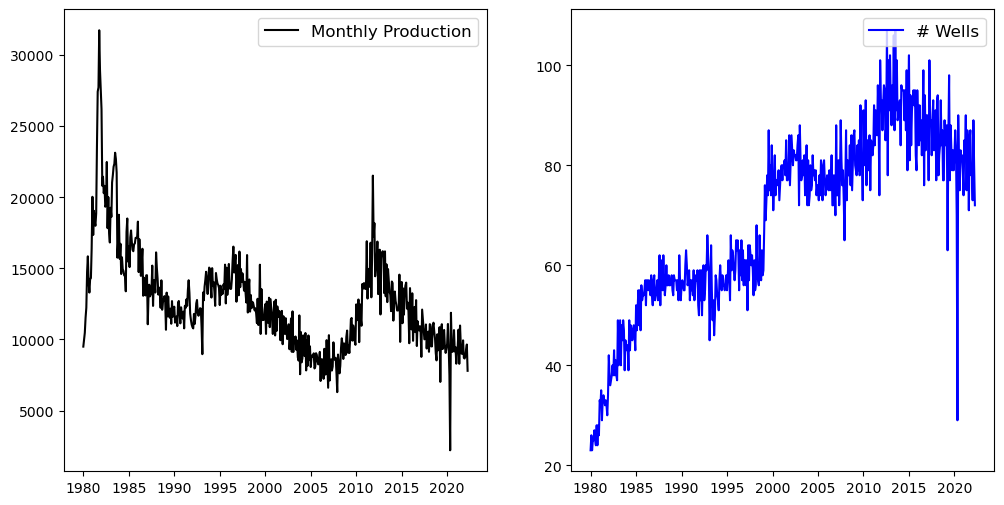

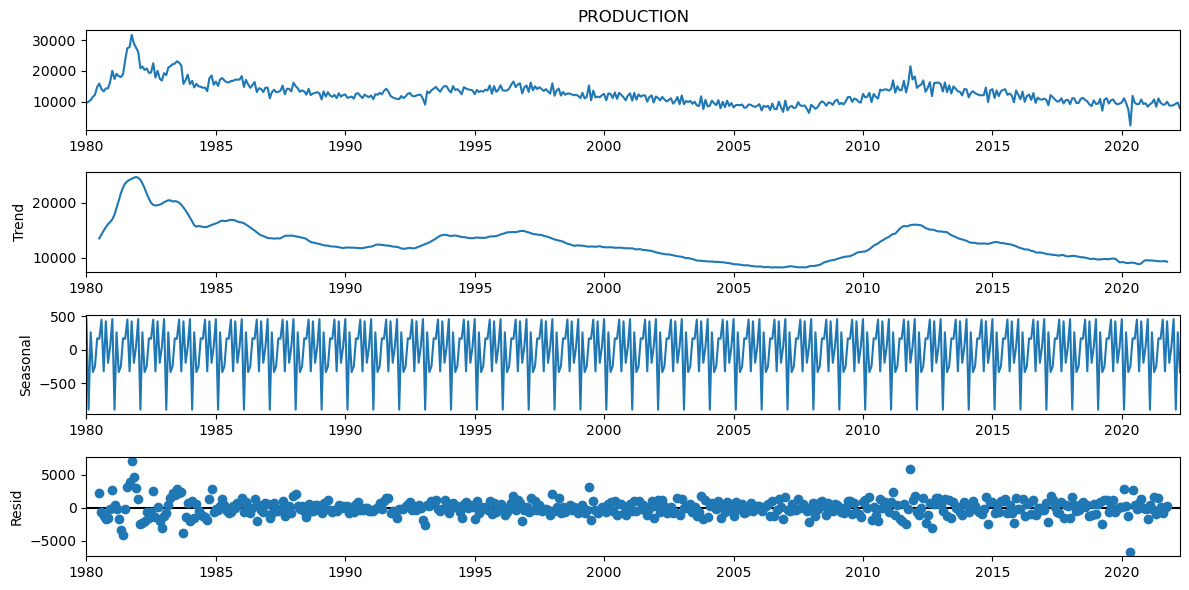

(472, 2) (36, 2)
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=8376.811, Time=0.08 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=8201.132, Time=0.63 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.76 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=8289.335, Time=0.10 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=8140.949, Time=1.83 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=2.60 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.87 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=8241.223, Time=0.45 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=8122.383, Time=2.13 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=8196.180, Time=0.27 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=3.04 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=1.15 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=8117.432, Time=2.52 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AIC=8189.444, Time=0.35 sec
 ARIMA(3,1,0)(2,1,1)[12]   

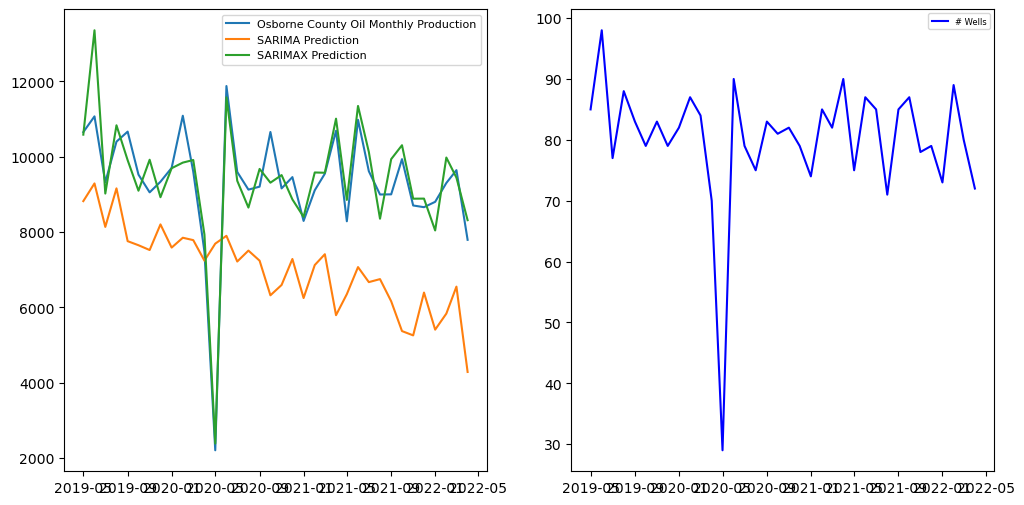

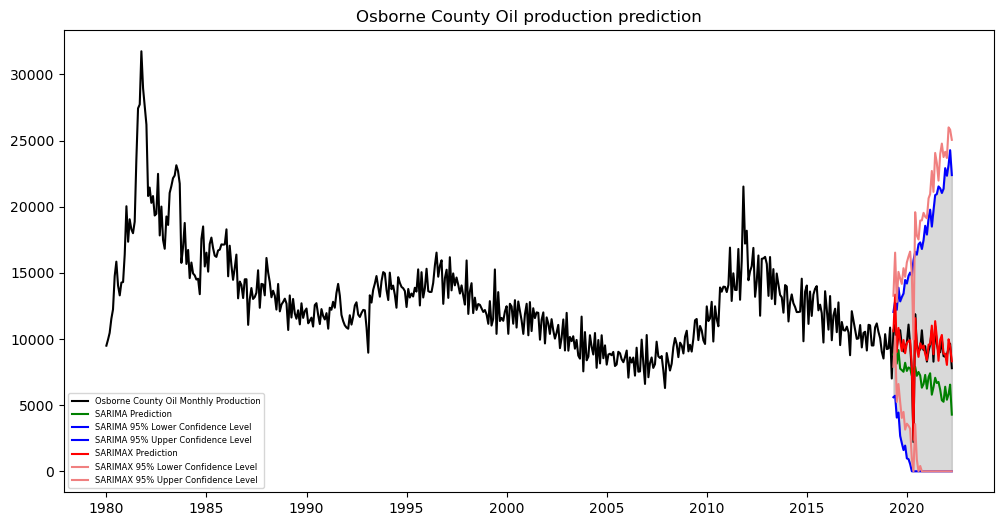

In [7]:
counties = df['NAME'].unique()
county = ''
input_message = "Pick a county you want to run the analysis:\n"

for i, county in enumerate(counties):
    input_message += f'{i+1}) {county}\n'

county = input(input_message)

if (county in counties) and (commodity in ['Oil', 'Gas']):
    print(county)
    tsa(df, county, commodity, test_obs = 36)
else:
    print('Enter valid inputs')